# Sandbox for testing and demonstrating augmentations.

In [73]:
# cd into project directory 
# %cd /home/bahaa/Documents/projects/ContrastiveLearningOfDenseDescriptor
%cd /home/baldeeb/Documents/Projects/dense_descriptors_and_acf/ContrastiveLearningOfDenseDescriptor

%load_ext autoreload
%autoreload 2

import numpy as np
import torch
# import torch.nn.functional as F 

# from scipy.spatial.transform import Rotation as R

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

/home/baldeeb/Documents/Projects/dense_descriptors_and_acf/ContrastiveLearningOfDenseDescriptor
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load image and get it's pixel distribution

image mean, std: [tensor([0.4638, 0.4494, 0.3598], grad_fn=<MeanBackward1>), tensor([0.2548, 0.1695, 0.1768], grad_fn=<StdBackward>)]


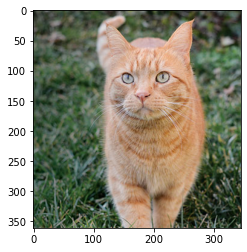

In [74]:
%matplotlib inline

def image_to_tensor(img): 
    t = torch.tensor(np.asarray(img).astype(float), requires_grad=True, dtype=torch.float32)
    t = t.permute(2, 0, 1).unsqueeze(0) / 255.0
    return t

def tensor_to_image(t, extension='jpg'):
    if extension == 'jpg':    
        im = t.squeeze(0).permute(1,2,0) * 255.0   # works for JPG
        return im.type(torch.int).numpy()
    elif extension == 'png':
        im = t.squeeze(0).permute(1,2,0).detach().numpy()  # Works for PNG
        return im * 255.0
    else:
        print('.............')

img = mpimg.imread("temp/sample.jpg")
im = image_to_tensor(img)
im_batch, im_ch, im_h, im_w = im.shape
img = tensor_to_image(im)
plt.imshow(img)

# get image stats:
im_mean = im.reshape(3, -1).mean(dim=1)
im_std = im.reshape(3, -1).std(dim=1)
im_stats = [im_mean, im_std]
print(f'image mean, std: {im_stats}')

### Test out some transforms

In [75]:
def visualize_transform(im, transform):
    fig = plt.figure()
    # fig.tight_layout()
    gs = fig.add_gridspec(1, 4)
    axs = gs.subplots()

    for ax in axs: 
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].imshow(tensor_to_image(im))

    resized_im = transform.forward(im)
    axs[1].imshow(tensor_to_image(resized_im))

    inv_results = transform.get_inverse()(resized_im)
    axs[2].imshow(tensor_to_image(inv_results))

    delta = im - inv_results
    axs[3].imshow(tensor_to_image(delta))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


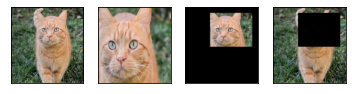

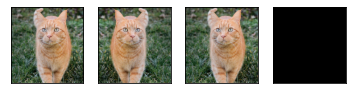

In [76]:
%matplotlib inline

from augmentations.transforms import RandomResizedCrop
resize_crop = RandomResizedCrop([im_h, im_w])
visualize_transform(im, resize_crop)

from augmentations.transforms import RandomHorizontalFlip
flip = RandomHorizontalFlip(0.9)
visualize_transform(im, flip)

# Testing augmentation.util functions

tensor(-1.5231, grad_fn=<MinBackward1>) tensor(1.6031, grad_fn=<MaxBackward1>)
tensor(-1.5231, grad_fn=<MinBackward1>) tensor(2.1024, grad_fn=<MaxBackward1>)


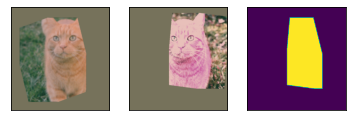

In [94]:
%matplotlib inline

from augmentations.util import union_of_augmented_images_in_original, image_de_normalize
from augmentations.geometrically_invertible_aug import GeometricallyInvertibleAugmentation as Augmentor

num_augs = 2
augmentors = [Augmentor(im.shape[-2:], img_stats=im_stats) for i in range(num_augs)]
augmented_ims = [aug(im) for aug in augmentors]

for i in augmented_ims:
    print(i.min(), i.max())

de_augmented_ims = [aug.geometric_inverse(x) for aug, x in zip(augmentors, augmented_ims)]

mask = union_of_augmented_images_in_original(augmentors)

## Visualize
fig = plt.figure()
gs = fig.add_gridspec(1, num_augs+1)
axs = gs.subplots()

for ax in axs: 
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

for i in range(num_augs):
    m = image_de_normalize(
        de_augmented_ims[i],
        data_mean = im_stats[0],
        data_std = im_stats[1],
        device = 'cpu')
    axs[i].imshow(tensor_to_image(m))

axs[num_augs].imshow(tensor_to_image(mask.unsqueeze(0).unsqueeze(0)))

# plt.figure()
# plt.imshow(tensor_to_image(augmented_ims[1]))
# plt.figure()
# plt.imshow(tensor_to_image(de_augmented_ims[1]))


## Testing normlization

Is this expected? is this problematic?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


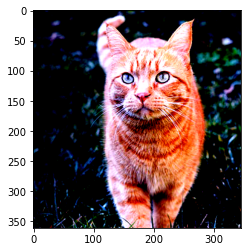

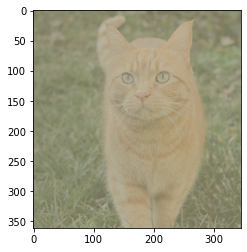

In [96]:
%matplotlib inline
from augmentations.util import union_of_augmented_images_in_original, image_de_normalize
from augmentations.geometrically_invertible_aug import GeometricallyInvertibleAugmentation as Augmentor

aug = Augmentor(im.shape[-2:], img_stats=im_stats)
m = aug.Normalize(im)
plt.imshow(tensor_to_image(m))
m = aug.de_normalize(im) 
plt.figure()
plt.imshow(tensor_to_image(m))


## Test De-augmentation

In [105]:
from augmentations.geometrically_invertible_aug import GeometricallyInvertibleAugmentation
from augmentations.util import image_de_normalize
aug = GeometricallyInvertibleAugmentation([im_h, im_w], img_stats=im_stats)

fig = plt.figure()
gs = fig.add_gridspec(1, 4)
axs = gs.subplots()

for ax in axs: 
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)


axs[0].imshow(tensor_to_image(im))

resized_im = aug(im)
axs[1].imshow(tensor_to_image(aug.de_normalize(resized_im, device='cpu')))

inv_results = aug.geometric_inverse(resized_im)
axs[2].imshow(tensor_to_image(aug.de_normalize(inv_results, device='cpu')))

delta = im - inv_results
axs[3].imshow(tensor_to_image(delta))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


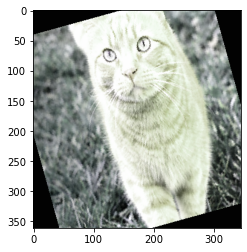

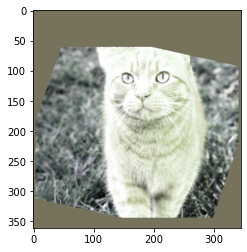

In [98]:
plt.imshow(tensor_to_image(aug.de_normalize(resized_im, device='cpu')))
plt.figure()
plt.imshow(tensor_to_image(aug.de_normalize(inv_results, device='cpu')))

In [99]:
import torch 
m1, m2 = torch.randint(0, 10, (2,4)), torch.randint(0, 10, (2,4))


def get_sorted_list_of_nonzero_indices_and_their_values(m):
    '''
    input shape: 
    '''
    indices = (m != 0).nonzero().T
    values = m[indices[0], indices[1]]
    sorted_values, i = torch.sort(values)
    sorted_indices = indices[:, i]
    return sorted_indices, sorted_values

def get_matches_from_int_masks(m1, m2):
    '''
    given 2 masks with integer values, returns lists of indices that which have the same integer in mask.
    
    mask shape: 
    '''
    i1, v1 = get_sorted_list_of_nonzero_indices_and_their_values(m1) 
    i2, v2 = get_sorted_list_of_nonzero_indices_and_their_values(m2)
    print(v1.shape, v2.shape) 
    v1_expanded = v1.expand((v2.shape[0], v1.shape[0])).T
    print(v1_expanded.shape)
    diff = (v1_expanded  - v2)
    matching_indices = (diff == 0).nonzero()
    if matching_indices.shape[0] == 0: return torch.tensor([]), torch.tensor([])
    v1_indices, v2_indices = [matching_indices[:, i].flatten() for i in range(2)]
    return v1[v1_indices], v2[v2_indices]

get_matches_from_int_masks(m1, m2)


torch.Size([7]) torch.Size([7])
torch.Size([7, 7])


(tensor([5, 8, 9, 9]), tensor([5, 8, 9, 9]))

# Test resizing augmentation

The goal is to perform contrastive learning on multiple scales.

In [100]:
def visualizes_aug_deaug(im_in, aug_in):
    fig = plt.figure()
    gs = fig.add_gridspec(1, 4)
    axs = gs.subplots()

    for ax in axs: 
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)


    axs[0].imshow(tensor_to_image(im_in))

    aug_im = aug_in(im_in)
    axs[1].imshow(tensor_to_image(aug_in.de_normalize(aug_im , device='cpu')))

    de_aug_im = aug_in.geometric_inverse(aug_im )
    axs[2].imshow(tensor_to_image(aug_in.de_normalize(de_aug_im, device='cpu')))

    delta = im_in - de_aug_im
    axs[3].imshow(tensor_to_image(aug_in.de_normalize(delta, device='cpu')))


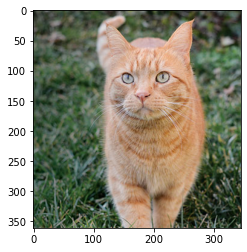

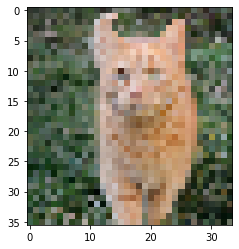

In [101]:
%matplotlib inline

from augmentations.geometrically_invertible_aug import GeometricallyInvertibleAugmentation
from augmentations.util import image_de_normalize
from torchvision.transforms import Resize as resize
from copy import deepcopy

new_im_shape = [int(im_h/10), int(im_w/10)]
resized_im = resize([new_im_shape[0], new_im_shape[1]])(im.clone())

plt.figure()
plt.imshow(tensor_to_image(im))
plt.figure()
plt.imshow(tensor_to_image(resized_im))


In [104]:
%matplotlib qt

aug = GeometricallyInvertibleAugmentation([im_h, im_w], img_stats=[im_mean, im_std])
# visualizes_aug_deaug(im, aug)

# visualizes_aug_deaug(resized_im, aug)
print("Visualizing the augmentation/de-augmentation of a resized image.")
aug.re_shape(new_im_shape)
visualizes_aug_deaug(resized_im, aug)

Visualizing the augmentation/de-augmentation of a resized image.


## Testing invertible affine transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


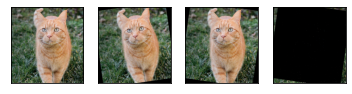

In [103]:
%matplotlib inline
from augmentations.transforms import Random2dAffineTransform 

random_affine = Random2dAffineTransform(im.shape, 45)
visualize_transform(im, random_affine)


# Temporary testing of loss function 

In [117]:
%matplotlib inline
from augmentations.util import union_of_augmented_images_in_original, image_de_normalize
from augmentations.geometrically_invertible_aug import GeometricallyInvertibleAugmentation as Augmentor

from loss.augmentation_loss import overlapping_region_positive_sample_loss

num_augs = 2
augmentors = [Augmentor(im.shape[-2:], img_stats=im_stats) for i in range(num_augs)]
augmented_ims = [aug(im) for aug in augmentors]
de_augmented_ims = [aug.geometric_inverse(x) for aug, x in zip(augmentors, augmented_ims)]

mask = union_of_augmented_images_in_original(augmentors)

indices = (mask.squeeze() == 1).nonzero()
overlapping_region_positive_sample_loss(meta)


In [147]:
from loss.contrastive_loss import get_match_loss
pseudo_descriptors = [d.squeeze() for d in de_augmented_ims]
get_match_loss(pseudo_descriptors, torch.stack([indices.T, indices.T]))

tensor(3.2651, grad_fn=<DivBackward0>)

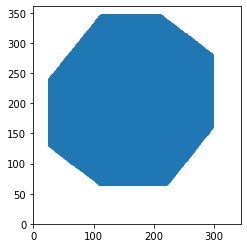

torch.Size([361, 344])

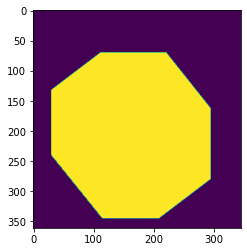

In [132]:
from matplotlib import pyplot as pyplot

fig, ax = plt.subplots()
ax.scatter(indices[:, 1], indices[:, 0])
ax.set_xlim(0,344)
ax.set_ylim(0,361)
ax.set_aspect('equal')
plt.show()

plt.figure()
plt.imshow(tensor_to_image(mask.unsqueeze(0).unsqueeze(0)))
mask.shape